# Overview

### What is model-based estimation and control?

The graphical model below illustrates a Partially Observable Markov Decision Process (POMDP).  Input actions $u$ are applied to a system to influence its state $x$ and subsequent observations of the state $y$.  The system is Markov because the state at time $k+1$ is assumed to be a function of the state at the previous time $k$.  The POMDP can be separated into two problems.

1. In the **optimal control problem**, the objective is to choose the action $u_k$ that minimizes the total cost $J=\sum_k^\infty c_k$.  Because the state is Markov, the choice of $u$ at the current time affects future states and costs, which is what makes the problem challenging.  The state $x$ is assumed directly observable.

2. Frequently the system is partially observable, i.e. the observation $y$ is directly measurable but the state $x$ is latent.  This motivates the **state estimation problem**, to recover the state $x$ from observations $y$ and previous states.  

![Graphical Model for a POMDP](./pomdp.png)

From the figure, we can see that 3 models comprise the POMDP.

1. The dynamics model predicts future states $x_{k+1}$ from current states $x_k$ and input actions $u_k$.  It describes how the state evolves in time.

2. The measurement model predicts measurements $y$ from states $x$.

3. The third model predicts the running cost $c$ as a function of states $x$ and actions $u$.

**How does this relate to reinforcement learning?**  In model-based reinforcement learning, we learn the models from data and use algorithms that solve the control and estimation problems based on these models.  In Sia, we solve the optimal control problem using Model Predictive Control (MPC) and the estimation problem using recursive Bayesian estimation.

**Where does the stochastic bit fit in?**  Because the dynamics and measurement models can be learned and the state is considered uncertain, belief is a first-class concept in Sia.  Dynamics and measurement equations are represented as probabilistic inference models $p(x_{k+1} | x_k, u_k)$ and $p(y | x)$.  The state is represented as a probability $p(x)$.  More on these representations in the example below.

**A note on convention.**  First, Sia uses a notion of cost typically found in optimal control.  Traditional reinforcement learning uses a notion of rewards, which is just the negative of the cost.  Second, Sia deals in continuous (real vector) action and state spaces typically found in control.  Reinforcement learning often focuses on discrete actions and states.  Third, Sia provides representations that support both first principles and learned models, while reinforcement learning typically focuses on learned models.  From here on out, we'll drop the discussion of reinforcement learning and refer to modeling, control and estimation directly to avoid confusion.  

**A note on discretization.**  The model is discrete time, which implies that there is a fixed time step between time indices.  Sia solves everything in discrete time, but provides continous time models that perform the discretization.  So if you formulate your dynamics in continuous time, don't worry, Sia will discretize them for you.

### Basic Usage
Sia is native C++, with Python bindings using Pybind11.  Python and C++ APIs are intended to match 1:1, so the Python documentation is helpful for both.  The C++ code uses Eigen for linear algebra, while the Python bindings use numpy.

In [1]:
import pysia as sia
import numpy as np

# Run the Python help for API documentation
# help(sia)

### A Simple Example

Now that we've gotten the theory out of the way, let's take a look at how to use Sia to solve a basic estimation and control problem.  Take a look at the nonholonomic vehicle in the diagram below.  The goal is to find a trajectory that takes the vehicle to the goal position and orientation.

![Diagram for a nonholonomic vehicle](./unicycle.png)

**Belief state.**  Let's start with a belief in our uncertain state.  This is typically called the state prior (i.e. a prior guess).  For the vehicle, we'll represent the system state as the position and orientation $(x, y, \phi)$ of the vehicle.  For simplicity, let's assume the uncertainty is Gaussian.  Sia provides other uncertainty representations, for more information see the Belief tutorial.
$$
p(x) = \mathcal{N}(x|\mu, \Sigma)
$$

Gaussian is a specialization of the `sia.Distribution` class.  Distributions provide methods for sampling and computing statistics such as log prob, mean, covariance, and mode.

In [2]:
Sigma = np.identity(3)
mu = np.array([0.4, 0, 0.1])  # x, y, phi
belief = sia.Gaussian(mean=mu, covariance=Sigma)

**Dynamics model.**  For simplicity, we'll use the unicycle model to model the vehicle kinematics.  In Sia, we can use the `sia.NonlinearGaussianDynamicsCT` class to define the nonlinear function with additive Gaussian noise of the form
$$
\dot{x} = f(x, u) + \eta, \quad \eta \sim \mathcal{N}(0, Q)
$$

Assume that the actions are the linear and angular velocities $u = (v, \omega)$.  We use the Gaussian noise to represent uncertainty in the process, e.g. due to unmodeled dynamics such as friction.  We can model the function $f$ for the unicycle
$$
\begin{pmatrix}
\dot{x} \\
\dot{y} \\
\dot{\phi}
\end{pmatrix} = \begin{pmatrix}
v \cos(\phi) \\
v \sin(\phi) \\
\omega
\end{pmatrix}
$$

For nonlinear systems, we can define lambda functions for the dynamics $f$.  Sia provides classes to handle both discrete time and continuous time (with methods to discretize) models.  For more information see the Models tutorials.

In [3]:
# Define the unicycle model
# state = (x, y, \phi)
# action = (v, \omega)
f = lambda x, u: np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

# Define the process noise
Q = 1e-5 * np.eye(3)

# Create the dynamics model
dynamics = sia.NonlinearGaussianDynamicsCT(dynamics=f, Qpsd=Q, dt=0.1)

**Measurement model.**  Let's assume that we can measure both the $x, y$ positions of the vehicle, but we can't directly measure the orientation $\phi$.  While the dynamics equation above is nonlinear, this measurement equation is linear.  In Sia, we can use the `sia.LinearGaussianMeasurementCT` class to define a measurement of the form
$$
y = H x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, R)
$$

Similar to the dynamics, Sia provides classes to handle both discrete time and continuous time (with methods to discretize) models.  For more information see the Models tutorials.

In [4]:
# Define the measurement equation, assume we cannot directly observe the orientation
# state = (x, y, \phi)
# action = (v, \omega)
H = np.array([[1, 0, 0], [0, 1, 0]])

# Define the measurement noise
R = 1e-6 * np.eye(2)

# Create the measurement model
measurement = sia.LinearGaussianMeasurementCT(H=H, Rpsd=R, dt=0.1)

**State estimator.**  In order to reach the goal, we'll need to estimate the latent state $\phi$ from the measurements of $(x, y)$.  For nonlinear Gaussian dynamics, the `sia.EKF` estimator is appropriate to perform the belief state update.  Sia provides other estimators such as the Kalman Filter `sia.KF` and particle filter `sia.PF` which are appropriate for different models.  For more information, see the Estimators tutorial.

In [5]:
# Create the estimator
ekf = sia.EKF(dynamics, measurement, belief)

**Model predictive controller.** The objective is to drive the robot to the goal state $(x,y,\phi)_{goal}$.  We can formulate this goal as a `sia.QuadraticCost` around the state and input.  For nonlinear dynamics, `sia.iLQR` is the appropriate algorithm.  The general form of the model predictive controller is a policy 
\begin{align}
u^* &= \arg\min_u J(x, u)\\
&s.t. \begin{array}{l}
\dot{x} = f(x, u) \\
x_0 = x_k 
\end{array}\\
\end{align}
where the policy finds the optimal action $u$ at the current time step for a cost function over a finite time horizon.  Each new belief update is used as the initial condition of the next optimization problem, which is seeded by the previous problem.  Other controllers include linear quadratic `sia.LQR` and model predictive path integrals `sia.MPPI`.  See the Controllers tutorial for more information.

In [6]:
# Define the cost
Qf = np.diag([50, 50, 20])     # final state cost
Q = np.zeros((3, 3))           # running state cost
R = np.diag([1, 1])            # running control cost
xd = np.array([0, 0, 3.1416])  # desired state
cost = sia.QuadraticCost(Qf, Q, R, xd)

# Define the initial control for a horizon of T = 40 time steps
T = 20
u0 = [np.array([0, 0]) for i in range(T)]

# Create the controller
ilqr = sia.iLQR(dynamics, cost, u0, max_iter=10)

**Simulation.**  With everything defined, we are now ready to simulate the system for a few steps.  A general template algorithm for state estimation and control is

```{eval=False}
x_0 <- initializeState()                  // Ground truth
b_0 <- initializeBelief()                 // Estimate
for k = 0,...:
  u_k <- policy(b_k)                      // Control
  x_k+1 <- integrateDynamics(x_k, u_k)    // Sim dynamics
  y_k+1 <- acquireMeasurement(x_k+1)      // Sim measurement
  b_k+1 <- estimate(b_k, u_k, y_k+1)      // Predict, correct
```

On hardware the ground truth state $x$ is often not available, and the dynamics and measurement functions are interactions with hardware.  Let's take a look at the simulation for the problem above.

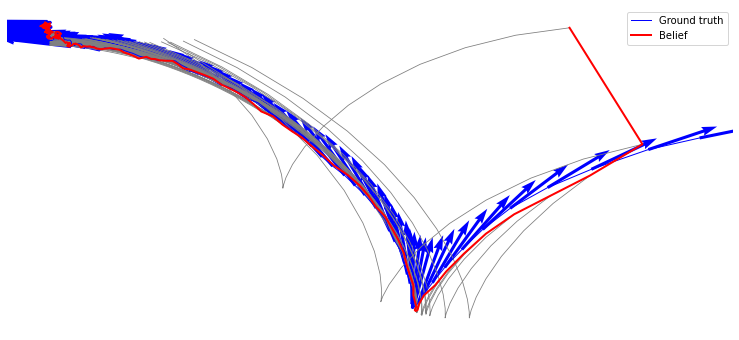

In [7]:
# Simulate for N time steps
N = 200
x = np.zeros((3, N))  # ground truth state
b = np.zeros((3, N))  # belief state mean

# Suppose the initial state doesn't quite match our belief
x[:, 0] = np.array([0.5, -0.1, 0.2])
b[:, 0] = belief.mean()

# Open a figure
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(13, 6))

# Run the simulation
for i in range(N-1):
    # Compute a control using the belief in state
    u = ilqr.policy(state=belief)

    # Simulate the system forward and sample from the propogated distributions
    x[:, i+1] = dynamics.dynamics(x[:, i], u).sample()
    y = measurement.measurement(x[:, i+1]).sample()

    # Update the belief based on the measurement we took and the control we applied
    belief = ekf.estimate(observation=y, control=u)
    b[:, i+1] = belief.mean()

    # Plot the trajectory
    traj = np.array(ilqr.states()).T
    ax.plot(traj[0, :], traj[1, :], lw=0.8, color='gray')
    
# Plot the resulting trajectory
ax.quiver(x[0, :], x[1, :], np.cos(x[2, :]), np.sin(x[2, :]), color="blue", scale=10)
ax.plot(x[0, :], x[1, :], "b", lw=1, label="Ground truth")
ax.plot(b[0, :], b[1, :], "r", lw=2, label="Belief")
ax.axis('off')
ax.legend();

And voila!  The initial belief state (red) exhibits a large error but quickly converges to the ground truth state (blue).  The controller finds a strategy to back the vehicle up before moving forward to adress the large heading error.  The controller continues to adjust the plan (gray rollouts) as the dynamics propogate and the belief state estimate improves.  The controller drives the vehicle to the goal state at $(x=0, y=0, \phi=\pi)$.  Because this system is stochastic, there will of course be some noise in the estimate and the tracking error.

That's a wrap on the overview.  For next steps, check out the tutorials.